### Three compartment equilibrium model

Context:
- Calculating the total equilibrium fraction of protein in each of the three compartments as a function of membrane affinity and dimerisation strength

Results:
- Increasing dimerisation and membrane affinity both favour membrane binding
- Relative preference for the plasma over internal membranes increases as dimerisation and/or membrane affinity increase

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker
from scipy.optimize import minimize

from src import lighten

%matplotlib inline

mpl.rcParams["figure.dpi"] = 150

if not os.path.exists("Figs"):
    os.mkdir("Figs")

In [2]:
# Model parameters
svr = 0.174 / 2
D = 0.005
dosage = 1.04e-8 / (1 - 0.62)

### Numerical solver

In [3]:
def concentration_tree(d, cfrac_smfrac):
    """
    d = total protein

    Concentrations described by a series of fractions (0-1)

    c (cfrac)
    s
        m (smfrac)
        n

    """

    cfrac, smfrac = [1 / (1 + np.exp(-i)) for i in cfrac_smfrac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac / (svr * D)
    n = s * (1 - smfrac) / (svr * D)
    return c, m, n  # concentrations


def calc_loss(cfrac_smfrac, dosage, ka, km, kn):
    # Concentrations
    c, m, n = concentration_tree(dosage, cfrac_smfrac)

    # Chemical potentials
    muc = np.log(c) - 0.5 * np.log(1 + 4 * ka * c + np.sqrt(1 + 8 * ka * c))
    mum = (
        np.log(m) - 0.5 * np.log(1 + 4 * ka * m + np.sqrt(1 + 8 * ka * m)) - np.log(km)
    )
    mun = (
        np.log(n) - 0.5 * np.log(1 + 4 * ka * n + np.sqrt(1 + 8 * ka * n)) - np.log(kn)
    )

    # Loss
    mu_all = np.array([muc, mum, mun])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)

    return loss

### Pie charts

In [4]:
def pie_panel(ax, ka, kn, km, dosage=dosage):
    # Optimise
    res = minimize(calc_loss, x0=[0, 0], args=(dosage, ka, km, kn)).x

    # Get concentrations
    c, m, n = concentration_tree(dosage, res)  # concentrations
    c_tot = c
    m_tot = m * svr * D
    n_tot = n * svr * D
    c, m, n = c_tot / dosage, m_tot / dosage, n_tot / dosage  # fractions

    # Figure
    ax.pie(
        [c, n, m],
        startangle=90,
        colors=["w", lighten("tab:blue"), "tab:blue"],
        wedgeprops={"linewidth": 0.5, "edgecolor": "k"},
    )
    ratio = m / n
    ax.text(0.75, -1, f"{ratio:.2f}", fontsize=9)

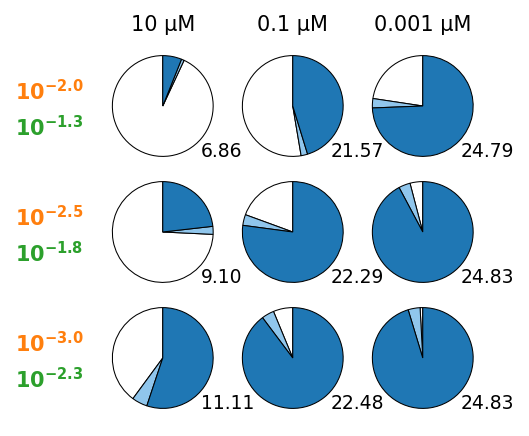

In [5]:
# Specify parameters
kas = [5, 7, 9]
kms = [2.0, 2.5, 3.0]

# Perform analysis and create figure
fig, ax = plt.subplots(3, 3)
for i, ka in enumerate(kas):
    for j, km in enumerate(kms):
        pie_panel(ax[j][i], ka=10**ka, kn=10 ** (km - 0.7), km=10**km)

ax[0][0].set_title("%s µM" % (10 ** (-kas[0] + 6)), fontsize=10)
ax[0][1].set_title("%s µM" % (10 ** (-kas[1] + 6)), fontsize=10)
ax[0][2].set_title("%s µM" % (10 ** (-kas[2] + 6)), fontsize=10)


def set_ylabel(ax, km):
    ylabel1 = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km),
        textprops=dict(
            color="tab:orange", size=10, rotation=0, ha="center", va="center"
        ),
    )
    ylabel2 = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km + 0.7),
        textprops=dict(
            color="tab:green", size=10, rotation=0, ha="center", va="center"
        ),
    )
    ylabel = VPacker(children=[ylabel1, ylabel2], align="center", pad=0, sep=5)
    anchored_ybox = AnchoredOffsetbox(
        loc=8,
        child=ylabel,
        pad=0.0,
        frameon=False,
        bbox_to_anchor=(-0.4, 0.3),
        bbox_transform=ax.transAxes,
        borderpad=0.0,
    )
    ax.add_artist(anchored_ybox)


set_ylabel(ax[0][0], kms[0])
set_ylabel(ax[1][0], kms[1])
set_ylabel(ax[2][0], kms[2])

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig("Figs/pie_eq.png", dpi=600, transparent=True)